# Computer Vision and Convolutional Neural Networks
## Binary Classification

In [352]:
import torch
import torch.nn as nn
import torch.utils.data.dataset as Dataset
import torchvision
import torchvision.datasets as dsets
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
from timeit import default_timer as timer
import os

## Pretty print
from pprint import pprint

print("Torch version:", torch.__version__)
print("Torchvision ver:", torchvision.__version__)

Torch version: 2.1.0
Torchvision ver: 0.16.0


Dataset Train Len:  60000
Dataset Test Len:  10000
Dataset Train type <class 'torch.Tensor'> torch.uint8
Dataset Test type <class 'torch.Tensor'> torch.uint8
(tensor([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]), tensor([1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000]))
{0: 'T-shirt/top',
 1: 'Trouser',
 2: 'Pullover',
 3: 'Dress',
 4: 'Coat',
 5: 'Sandal',
 6: 'Shirt',
 7: 'Sneaker',
 8: 'Bag',
 9: 'Ankle boot'}
Test Dataset <class 'torchvision.datasets.mnist.FashionMNIST'>
Test loader <class 'torch.utils.data.dataloader.DataLoader'>
Batch shape: torch.Size([32, 1, 28, 28]) torch.float32
Sample shape: torch.Size([1, 28, 28]) torch.float32
Sample Label: 6 Shirt torch.int64


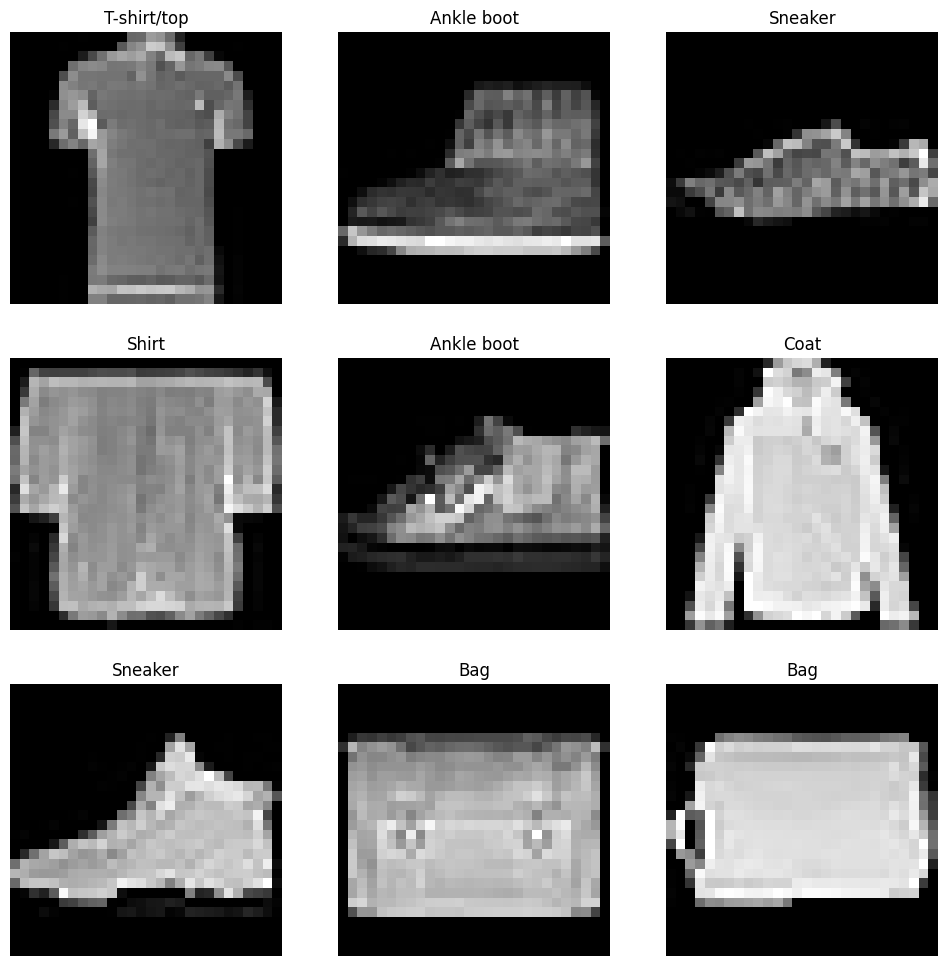

In [282]:
# Download Dataset
train_dataset = dsets.FashionMNIST(
    root='~/Developer/Datasets', 
    train=True, 
    transform=transforms.ToTensor(), 
    target_transform=None,
    download=True)

test_dataset = dsets.FashionMNIST(
    root='~/Developer/Datasets', 
    train=False, 
    transform=transforms.ToTensor(), 
    target_transform=None,
    download=True)

# Look at dataset
print("Dataset Train Len: ", len(train_dataset.data))
print("Dataset Test Len: ", len(test_dataset.data))
print("Dataset Train type", type(train_dataset.data), train_dataset.data.dtype)
print("Dataset Test type", type(test_dataset.data), test_dataset.data.dtype)
print(torch.unique(test_dataset.targets, return_counts=True))
classes = dsets.FashionMNIST.classes
classes_dict = {i: x for i, x in enumerate(classes)}


pprint(classes_dict)

BATCH_SIZE = 32
# Load Dataset
train_loader = torch.utils.data.DataLoader(
    dataset=train_dataset, 
    batch_size=BATCH_SIZE, 
    shuffle=True)

test_loader = torch.utils.data.DataLoader(
    dataset=test_dataset, 
    batch_size=BATCH_SIZE, 
    shuffle=False)

# Look at a sample
print("Test Dataset", type(test_dataset))
print("Test loader", type(test_loader))
sample = next(iter(train_loader))
print("Batch shape:", sample[0].shape, sample[0].dtype)
print("Sample shape:", sample[0][0].shape, sample[0].dtype)
print("Sample Label:", sample[1][0].item(), classes_dict[sample[1][0].item()], sample[1][0].dtype)



fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(12, 12))
for i in range(9):
    random_index = torch.randint(0, 32, (1,)).item()
    ax = axes[i//3, i%3]
    ax.imshow(sample[0][random_index][0], cmap='gray')
    ax.set_title(classes_dict[sample[1][random_index].item()])
    ax.axis('off')
    


In [283]:
# Device agnostic code
if torch.cuda.is_available():
    device = torch.device("cuda")
elif torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    device = torch.device("cpu")
    
device = "mps"

class FashionMnistLinear(nn.Module):
    def __init__(self):
        super(FashionMnistLinear, self).__init__()
        # Convolutional Layers
        # self.conv1 = nn.Conv2d(in_channels=1, out_channels=16, kernel_size=5, stride=1, padding=2)
        # self.relu = nn.ReLU()
        
        
        # Linear Layers
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(in_features=28*28, out_features=10, bias=True)
        self.fc2 = nn.Linear(in_features=10, out_features=10, bias=True)
        # self.sigmoid = nn.Sigmoid()
        
        
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """Forward pass of the network.
        """
        x = self.flatten(x)
        x = self.fc1(x)
        x = self.fc2(x)
        return x
    
class FashionMnistNonLinear(nn.Module):
    def __init__(self):
        super(FashionMnistNonLinear, self).__init__()
        self.flatten = nn.Flatten()
        self.relu1 = nn.ReLU()
        self.relu2 = nn.ReLU()
        self.fc1 = nn.Linear(in_features=28*28, out_features=10, bias=True)
        self.fc2 = nn.Linear(in_features=10, out_features=10, bias=True)
        
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """"""
        x  = self.flatten(x)
        x = self.relu1(x)
        x = self.fc1(x)
        x = self.relu2(x)
        x = self.fc2(x)
        return x
    
class FashionMnistCNN(nn.Module):
    def __init__(self):
        super(FashionMnistCNN, self).__init__()
        # Convolutional Layers
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=16, 
                               kernel_size=3, stride=1, padding=2)
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=16,
                               kernel_size=3, stride=1, padding=1)
        self.relu = nn.ReLU()
        self.maxpool = nn.MaxPool2d(kernel_size=2)
        
        # Linear Layers
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(in_features=7*7*16, out_features=10, bias=True)
        self.fc2 = nn.Linear(in_features=10, out_features=10, bias=True)
        self.sigmoid = nn.Sigmoid()
        
        
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """Forward pass of the network.
        """
        # Block 1
        x = self.conv1(x)
        x = self.relu(x)
        x = self.conv2(x)
        x = self.relu(x)
        x = self.maxpool(x)
        
        # Block 2
        x = self.conv2(x)
        x = self.relu(x)
        x = self.conv2(x)
        x = self.relu(x)
        x = self.maxpool(x)
            
        # Dense 
        x = self.flatten(x)
        x = self.fc1(x)
        x = self.fc2(x)
        return x
        
        

In [284]:
model = FashionMnistCNN()
model.to(device)

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.1)



In [363]:
for name, param in model.named_parameters():
    if param.grad is not None:
        print(f'Parameter: {name}, "Regular Shape", {param.shape}, Gradient Shape: {param.grad.shape}')

Parameter: conv1.weight, "Regular Shape", torch.Size([16, 1, 3, 3]), Gradient Shape: torch.Size([16, 1, 3, 3])
Parameter: conv1.bias, "Regular Shape", torch.Size([16]), Gradient Shape: torch.Size([16])
Parameter: conv2.weight, "Regular Shape", torch.Size([16, 16, 3, 3]), Gradient Shape: torch.Size([16, 16, 3, 3])
Parameter: conv2.bias, "Regular Shape", torch.Size([16]), Gradient Shape: torch.Size([16])
Parameter: fc1.weight, "Regular Shape", torch.Size([10, 784]), Gradient Shape: torch.Size([10, 784])
Parameter: fc1.bias, "Regular Shape", torch.Size([10]), Gradient Shape: torch.Size([10])
Parameter: fc2.weight, "Regular Shape", torch.Size([10, 10]), Gradient Shape: torch.Size([10, 10])
Parameter: fc2.bias, "Regular Shape", torch.Size([10]), Gradient Shape: torch.Size([10])


In [361]:
def print_train_time(start: float, end: float, device: torch.device = None) -> float:
    """Prints the time taken to train the model.
    """
    
    if device:
        print(f"Training time: {end-start:.2f} seconds on {device}")
    else:
        print(f"Training time: {end-start:.2f} seconds")
        
    return end-start

from helper_functions import accuracy_fn

# Train the model
def train(model: nn.Module, 
            train_loader: torch.utils.data.dataloader.DataLoader,
            test_loader: torch.utils.data.dataloader.DataLoader,
            optimizer: torch.optim.Optimizer,
            loss_fn: torch.nn.Module,
            device: torch.device = 'cpu') -> dict:
    
    EPOCHS = 20
    history = { "train_loss" : [], "train_acc" : [],  "test_loss" : [], "test_acc" : [] }
    
    # Training
    for epoch in tqdm(range(EPOCHS)):
        # Train step
        train_loss, train_acc = train_step(model, loss_fn, train_loader, optimizer, device)
        history["train_loss"].append(train_loss)
        history["train_acc"].append(train_acc)
            
        # Testing step
        test_loss, test_acc = test_step(model, loss_fn, test_loader, device)
        history["test_loss"].append(test_loss)
        history["test_acc"].append(test_acc)
        
        # Print progress 
        if epoch % 1 == 0:
            print(f"Epoch: {epoch}/{EPOCHS}, Train loss: {train_loss:.5f}, Train acc: {train_acc} | Test loss: {test_loss:.5f}, Test acc: {test_acc:.2f}%")
             
    return history       

# Train Step
def train_step(model: nn.Module,
                loss_fn: torch.nn.Module,
                data_loader: torch.utils.data.dataloader.DataLoader,
                optimizer: torch.optim.Optimizer,
                device: torch.device = 'cpu') -> dict:
     """Peform a train step on model on data_loader."""
     train_loss, train_acc = 0.0, 0.0
     model.train()                                       # Set model to training mode
     for X, y in data_loader:
        X, y = X.to(device), y.to(device)               # Move to device
        train_pred = model(X)                           # Forward pass
        loss = loss_fn(train_pred, y)                   # Calculate loss
        train_loss += loss.item()                       # Accumulate loss
        train_acc += (train_pred.argmax(dim=1) == y).sum().item() / len(y) * 100
        optimizer.zero_grad()                           # Optimizer zero grad
        loss.backward()                                 # Backward pass
        optimizer.step()                                # Update parameters
    
     train_loss /= len(data_loader.dataset)              # Average loss per epoch
     train_acc /= len(data_loader)                       # Average accuracy per epoch
     return train_loss, train_acc

# Test Step
def test_step(model: nn.Module,
              loss_fn: torch.nn.Module,
              data_loader: torch.utils.data.dataloader.DataLoader,
              device: torch.device = 'cpu') -> dict:
    """Peform a test on model on test_loader."""
    test_loss, test_acc = 0.0, 0.0
    model.eval()                                        # Set model to evaluation mode
    with torch.inference_mode():
        for X, y in data_loader:
            X, y = X.to(device), y.to(device)           # Move to device
            test_pred = model(X)                        # Forward pass
            test_loss += loss_fn(test_pred, y)          # Accumulate loss
            test_acc += (test_pred.argmax(dim=1) == y).sum().item() / len(y) * 100
            

        test_loss /= len(data_loader)
        test_acc /= len(data_loader)
    return test_loss, test_acc

start_time = timer()
history = train(model, train_loader, test_loader, optimizer, loss_fn, device)
end_time = timer()
print_train_time(start_time, end_time) 

# Add to results_history
results_history = {}

  0%|          | 0/20 [00:00<?, ?it/s]


AttributeError: 'torch.Size' object has no attribute 'item'

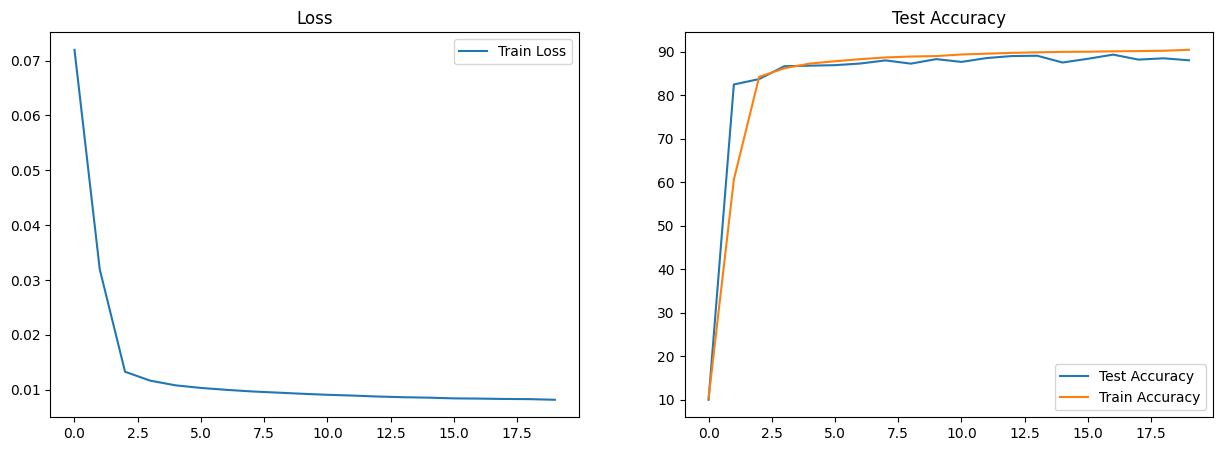

In [289]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))
axes[0].set_title("Loss")
axes[0].plot(history["train_loss"], label="Train Loss")

# axes[0].set_title("Test Loss")
# axes[0].plot(history["test_loss"], label="Test Loss")
axes[0].legend()

axes[1].set_title("Test Accuracy")
axes[1].plot(history["test_acc"], label="Test Accuracy")
axes[1].plot(history["train_acc"], label="Train Accuracy")
axes[1].legend()


{'acc': 88.06908945686901,
 'loss': 0.3361257016658783,
 'model_name': 'FashionMnistCNN'}


Text(95.72222222222221, 0.5, 'True')

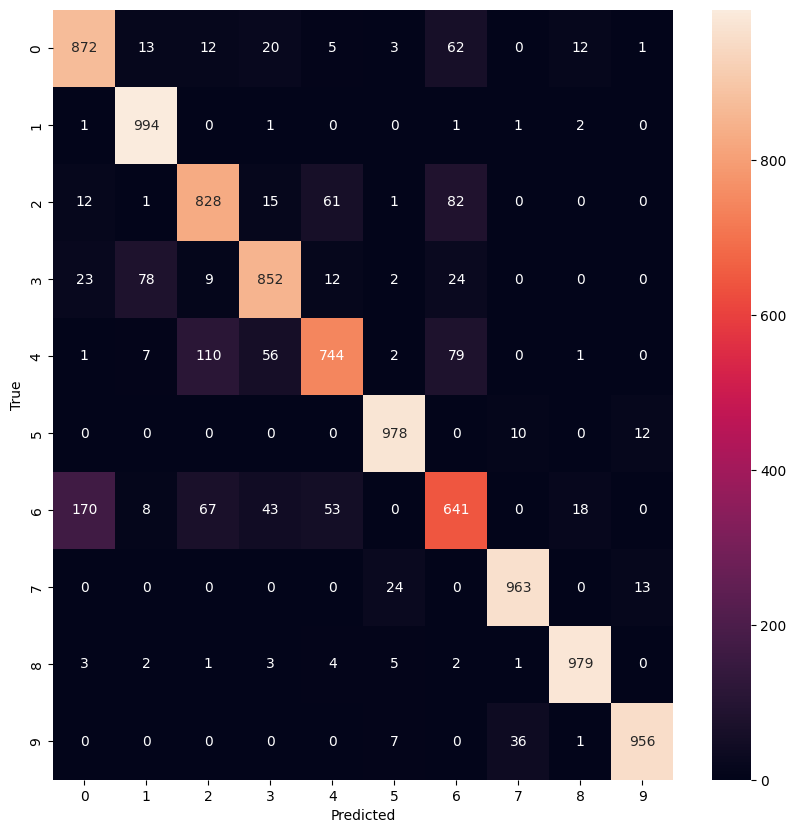

In [347]:
# Evaluate
def eval_model(model: nn.Module, 
               test_loader: torch.utils.data.dataloader.DataLoader, 
               loss_fn: nn.Module) -> dict:
    loss, acc = 0.0, 0.0
    confusion_matrix = torch.zeros(10, 10)
    
    model.eval()
    with torch.inference_mode():
        for (X, y) in test_loader:
            X, y = X.to(device), y.to(device)
            test_pred = model(X)
            loss += loss_fn(test_pred, y)
            acc += (test_pred.argmax(dim=1) == y).sum().item() / len(y) * 100
            
            # Confusion matrix
            for t, p in zip(y.view(-1), test_pred.argmax(dim=1).view(-1)):
                confusion_matrix[t.long(), p.long()] += 1
    
        loss /= len(test_loader)
        acc /= len(test_loader)
        
    return {
        "model_name": model.__class__.__name__,
        "loss": loss.item(),
        "acc": acc
    }, confusion_matrix
    
results, confusion_matrix = eval_model(model, test_loader, loss_fn)
pprint(results)

[Text(0, 0.5, 'T-shirt/top'),
 Text(0, 1.5, 'Trouser'),
 Text(0, 2.5, 'Pullover'),
 Text(0, 3.5, 'Dress'),
 Text(0, 4.5, 'Coat'),
 Text(0, 5.5, 'Sandal'),
 Text(0, 6.5, 'Shirt'),
 Text(0, 7.5, 'Sneaker'),
 Text(0, 8.5, 'Bag'),
 Text(0, 9.5, 'Ankle boot')]

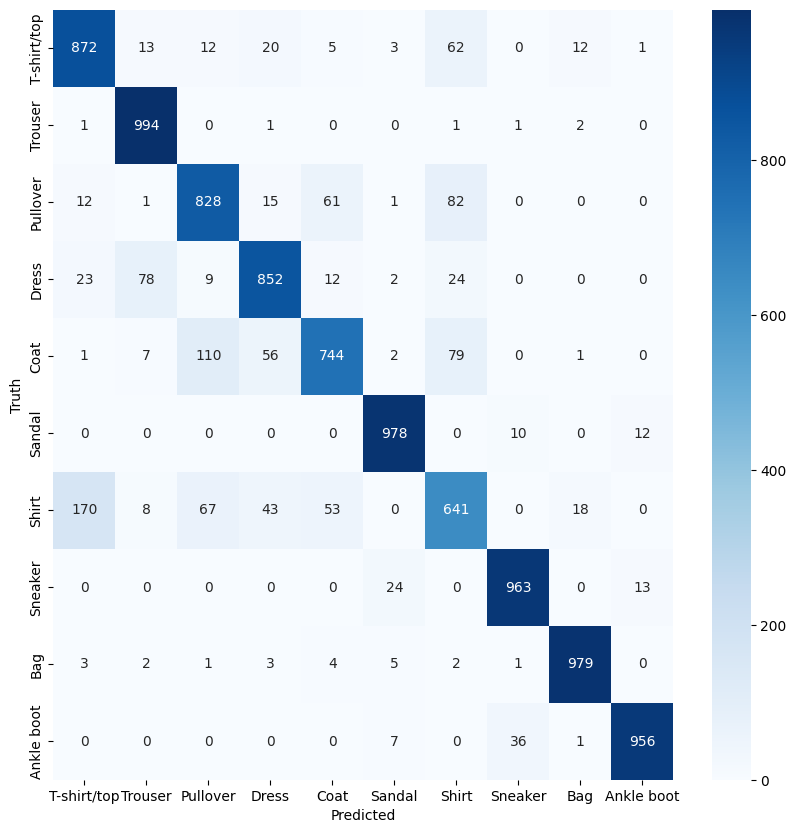

In [351]:
# Plot confusion matrix
import seaborn as sns
fig, ax = plt.subplots(figsize=(10, 10))
sns.heatmap(confusion_matrix, annot=True, ax=ax, fmt='g', cmap='Blues')
plt.xlabel("Predicted")
plt.ylabel("Truth")
# Labels with class names
ax.xaxis.set_ticklabels(classes)
ax.yaxis.set_ticklabels(classes)


In [295]:
all_results = {}

In [296]:
import pandas as pd

all_results[results["model_name"]] = results
df = pd.DataFrame(all_results)

In [297]:
df.head()

,FashionMnistCNN
acc,88.069089
loss,0.336126
model_name,FashionMnistCNN


In [339]:
# Make predictions
def make_predictions(mode: nn.Module, 
                     data: list,
                     device: torch.device = 'cpu') -> list:
    pred_probs = []
    model.eval()
    with torch.inference_mode():
        for X in data:
            X = X.to(device)
            X = X.unsqueeze(0)
            pred_prob = model(X)
            pred_probs.append(pred_prob)
            
    return pred_probs
        
# Get random samples    
import random
test_samples = []
test_labels = []
for sample, label in random.sample(list(test_dataset), k=9):
    test_samples.append(sample)
    test_labels.append(label)
    
# View the first sample shape
print(test_samples[0].shape)
print(test_labels[0])

# plt.imshow(test_samples[0][0], cmap='gray')
# plt.title(classes_dict[test_labels[0]])

torch.Size([1, 28, 28])
6


[6, 6, 9, 4, 0, 3, 2, 0, 0]


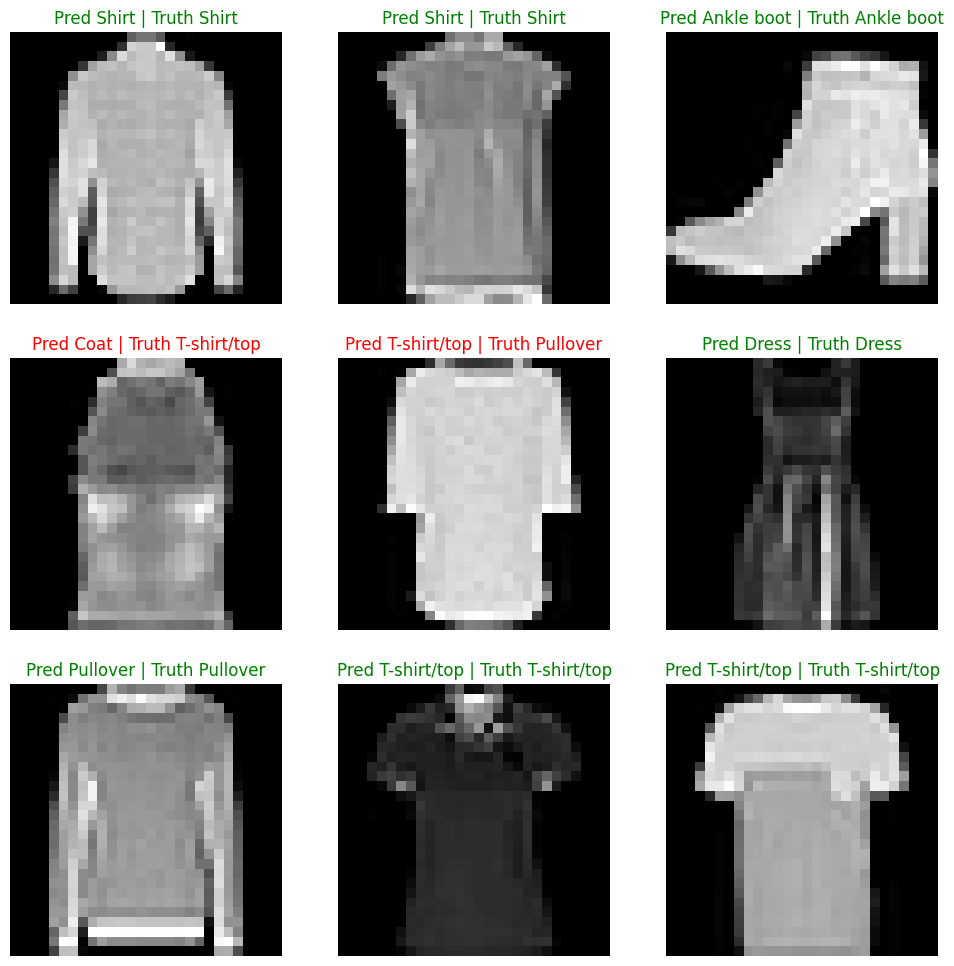

In [344]:
pred_prob = make_predictions(model, test_samples, device)
pred_classes = [ p.argmax(dim=1).item() for p in pred_prob ]
print(pred_classes)

# Plot 
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(12, 12))
for i in range(9):
    ax = axes[i//3, i%3]
    ax.imshow(test_samples[i][0], cmap='gray')
    title_text = f"Pred {classes_dict[pred_classes[i]]} | Truth {classes_dict[test_labels[i]]}"
    ax.set_title(title_text)
    
    # Change color based on prediction
    if pred_classes[i] == test_labels[i]:
        ax.set_title(title_text, color='green')
    else:
        ax.set_title(title_text, color='red')
    ax.axis('off')


In [353]:
model_path = os.path.expanduser(f"~/Developer/Models/{model.__class__.__name__}_0.pth")
torch.save(model.state_dict(), model_path)

In [359]:
model_load = FashionMnistCNN()
model_load.load_state_dict(torch.load(model_path))


OrderedDict([('conv1.weight', tensor([[[[-5.3459e-01, -2.3625e-01, -2.5199e-01],
          [ 7.5649e-02, -4.8613e-02, -7.4161e-02],
          [ 4.2381e-02,  2.7734e-02, -8.7867e-02]]],


        [[[ 4.3435e-02, -3.4950e-01, -1.3636e+00],
          [ 4.3022e-01, -3.5079e-01, -1.0752e-01],
          [ 4.9236e-01, -7.1837e-01,  5.9161e-01]]],


        [[[ 8.2726e-02, -1.7517e-01, -9.9316e-03],
          [ 2.5390e-02,  1.7954e-01, -3.3081e-01],
          [ 2.8219e-02, -1.2605e-01,  7.7734e-02]]],


        [[[ 3.7431e-02,  7.6235e-02, -2.1302e-01],
          [-2.4305e-01, -8.4471e-02, -2.5611e-01],
          [-1.0810e-01, -8.7937e-02,  7.7100e-02]]],


        [[[-2.6200e-01, -8.5548e-02, -2.8661e-01],
          [-2.7318e-02,  7.6511e-02,  1.2667e-01],
          [-3.8490e-01, -2.6422e-02,  1.5315e-01]]],


        [[[-5.4985e-01,  3.2779e-01, -7.0674e-02],
          [-9.1952e-01, -1.1635e+00,  4.3681e-01],
          [-3.9042e-01, -5.4008e-01,  7.5000e-01]]],


        [[[-3.0930e-01, -2.2